## **Install Libraries**

In [823]:
!pip install geopandas

## **Import Libraries**

In [0]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
import scipy.stats as stats

sns.set_palette("Set2")
sns.set_style("ticks")

## **Import Data**

In [0]:
crimes = pd.read_csv("https://github.com/fescobar96/Crime-Prediction-in-San-Francisco/raw/master/Data/train.zip")

In [0]:
weather = pd.read_csv("https://raw.githubusercontent.com/fescobar96/Crime-Prediction-in-San-Francisco/master/Data/sf_weather.csv")

In [0]:
football = pd.read_csv("https://raw.githubusercontent.com/fescobar96/Crime-Prediction-in-San-Francisco/master/Data/49schedule.csv")

In [828]:
y_2019 = pd.read_csv("/content/2019.csv", header=1)
y_2019.head()

,Week,Day,Date,Unnamed: 3,Unnamed: 4,Unnamed: 5,OT,Rec,Unnamed: 8,Opp,Tm,Opp.1,1stD,TotYd,PassY,RushY,TO,1stD.1,TotYd.1,PassY.1,RushY.1,TO.1,Offense,Defense,Sp. Tms
0,1,Sun,September 8,4:25PM ET,boxscore,W,NaN,1-0,@,Tampa Bay Buccaneers,31.0,17.0,17.0,256.0,158.0,98.0,2.0,21.0,295.0,174.0,121.0,4.0,-6.51,19.12,1.10
1,2,Sun,September 15,1:00PM ET,boxscore,W,NaN,2-0,@,Cincinnati Bengals,41.0,17.0,27.0,571.0,312.0,259.0,1.0,14.0,316.0,291.0,25.0,1.0,27.34,1.14,-6.64
2,3,Sun,September 22,4:25PM ET,boxscore,W,NaN,3-0,NaN,Pittsburgh Steelers,24.0,20.0,26.0,436.0,268.0,168.0,5.0,11.0,239.0,160.0,79.0,2.0,-3.72,10.20,0.12
3,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Bye Week,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,Mon,October 7,8:15PM ET,boxscore,W,NaN,4-0,NaN,Cleveland Browns,31.0,3.0,22.0,446.0,171.0,275.0,NaN,9.0,180.0,78.0,102.0,4.0,13.38,22.56,-10.50


## **Data Preprocessing - San Francisco Crimes**

In [829]:
crimes_missing = pd.DataFrame(crimes.isnull().mean()*100, columns=["Missing Values %"])
crimes_missing

,Missing Values %
Dates,0.0
Category,0.0
Descript,0.0
DayOfWeek,0.0
PdDistrict,0.0
Resolution,0.0
Address,0.0
X,0.0
Y,0.0


In [0]:
crimes_original = crimes.copy()
crimes_original["Dates"] = pd.to_datetime(crimes["Dates"])
crimes_original.set_index(keys=crimes_original["Dates"], inplace=True)
crimes_original.drop(columns=["Dates"], inplace=True)

In [0]:
crimes.drop(columns=["Category", "Descript", "Resolution", "Address", "X", "Y"], inplace=True)

In [0]:
crimes["Dates"] = pd.to_datetime(crimes["Dates"]).dt.date

In [833]:
crimes.head()

,Dates,DayOfWeek,PdDistrict
0,2015-05-13,Wednesday,NORTHERN
1,2015-05-13,Wednesday,NORTHERN
2,2015-05-13,Wednesday,NORTHERN
3,2015-05-13,Wednesday,NORTHERN
4,2015-05-13,Wednesday,PARK


## **Data Preprocessing - Weather**

In [834]:
weather_missing = pd.DataFrame(weather.isnull().mean()*100, columns=["Missing Values %"])
weather_missing

,Missing Values %
date,0.0
avg_temp (celsius),0.0
precipitation (mm),0.0
wind_speed (km/h),0.0
visibility (km),0.0
"moon_illumination, %",0.0


In [0]:
weather["Dates"] = pd.to_datetime(weather["date"]).dt.date

In [0]:
weather_original = weather.copy()
weather_original["Dates"] = pd.to_datetime(weather["Dates"])
weather_original.set_index(keys=weather_original["Dates"], inplace=True)
weather_original.drop(columns=["Dates"], inplace=True)

In [0]:
weather.drop(columns=["date", "moon_illumination, %"], inplace=True)

In [838]:
weather.head()

,avg_temp (celsius),precipitation (mm),wind_speed (km/h),visibility (km),Dates
0,9,0.00,3,15.0,2003-01-01
1,10,0.00,5,15.0,2003-01-02
2,10,0.00,5,15.0,2003-01-03
3,11,0.00,5,15.0,2003-01-04
4,11,0.25,5,6.0,2003-01-05


## **Data Preprocessing - Football Schedule**

In [839]:
football_missing = pd.DataFrame(football.isnull().mean()*100, columns=["Missing Values %"])
football_missing

,Missing Values %
Date,0.0
Output,0.0
Home,0.0


In [0]:
football["Dates"] = pd.to_datetime(football["Date"])
football.drop(columns=["Date"], inplace=True)
football.rename(columns={"Output":"NFL_Output",
                 "Home":"NFL_Home"}, inplace=True)
football["NFL_Game_Day"] = 1

In [841]:
football.head()

,NFL_Output,NFL_Home,Dates,NFL_Game_Day
0,W,1.0,2003-09-07,1
1,L,0.0,2003-09-14,1
2,L,1.0,2003-09-21,1
3,L,0.0,2003-09-28,1
4,W,1.0,2003-10-05,1


## **Merge crimes, weather, and football schedule dataframes**

In [0]:
data=pd.merge(crimes, weather, how="left", on="Dates")
data["Dates"] = pd.to_datetime(data["Dates"])
data=pd.merge(data, football, how="left", on="Dates") #Added this line
data["Dates"] = pd.to_datetime(data["Dates"])
data.set_index(keys=data["Dates"], inplace=True)
data.drop(columns=["Dates"], inplace=True)

In [0]:
data.rename(columns={"avg_temp (celsius)":"avg_temp",
             "precipitation (mm)":"precipitation",
             "wind_speed (km/h)":"wind_speed",
             "visibility (km)":"visibility"
             }, inplace=True)

In [0]:
data["precipitation"].replace({"T":np.nan}, inplace=True)
data["precipitation"] = data["precipitation"].astype("float")

In [0]:
data["wind_speed"].replace({"Waning Crescent, 14":np.nan}, inplace=True)
data["wind_speed"] = data["wind_speed"].astype("float")

In [0]:
data["NFL_Output"].fillna("No Game", inplace=True)
data["NFL_Home"].fillna(3, inplace=True) #3 Indicates no game for that day
data["NFL_Game_Day"].fillna(0, inplace=True)

In [0]:
data["NFL_Home"].replace({"0": 0,
                          "1":1,
                          "0.0":0,
                          "1.0":1}, inplace=True)

In [0]:
data["NFL_Game_Day"] = data["NFL_Game_Day"].astype("int")

In [849]:
data.head()

,DayOfWeek,PdDistrict,avg_temp,precipitation,wind_speed,visibility,NFL_Output,NFL_Home,NFL_Game_Day
Dates,,,,,,,,,
2015-05-13,Wednesday,NORTHERN,15,0.0,19.0,40.0,No Game,3,0
2015-05-13,Wednesday,NORTHERN,15,0.0,19.0,40.0,No Game,3,0
2015-05-13,Wednesday,NORTHERN,15,0.0,19.0,40.0,No Game,3,0
2015-05-13,Wednesday,NORTHERN,15,0.0,19.0,40.0,No Game,3,0
2015-05-13,Wednesday,PARK,15,0.0,19.0,40.0,No Game,3,0


## **Crimes by Year**

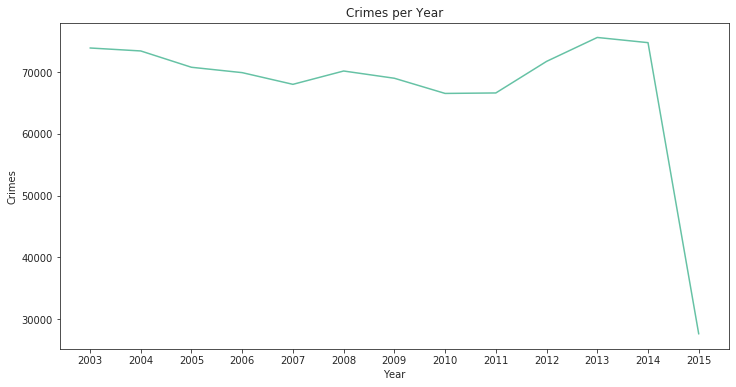

In [850]:
plt.figure(figsize=(12,6))
yearly_crimes = data["DayOfWeek"].resample("Y").count()
years = [x for x in range(2003, 2016)]
sns.lineplot(x=years, y=yearly_crimes.values)
plt.xlabel("Year")
plt.ylabel("Crimes")
plt.xticks(years, years)
plt.title("Crimes per Year")
plt.show()

## **Crimes by Day of the Week**

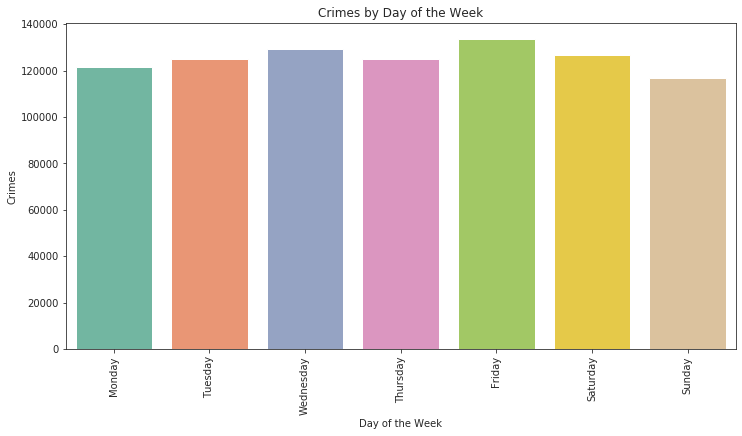

In [851]:
plt.figure(figsize=(12,6))
sns.countplot(x="DayOfWeek", data=data, order=["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"])
plt.title("Crimes by Day of the Week")
plt.xlabel("Day of the Week")
plt.ylabel("Crimes")
plt.xticks(rotation=90)
plt.show()

## **Crimes per Hour**

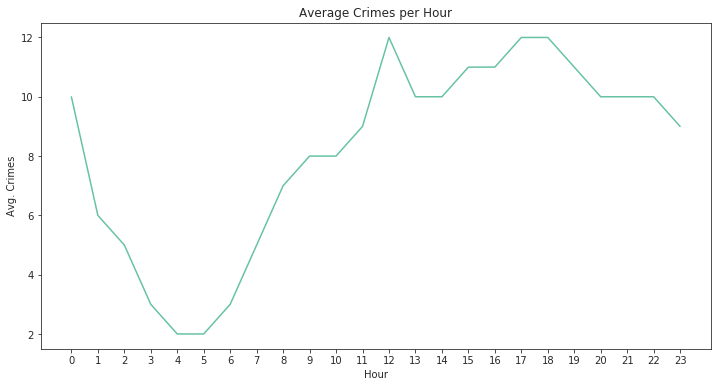

In [852]:
plt.figure(figsize=(12,6))
hourly_crimes = crimes_original["DayOfWeek"].resample("H").count()
hours = [x for x in range(0, 24)]
hourly_crimes = round(hourly_crimes.groupby(hourly_crimes.index.hour).mean(), 0)
hourly_crimes.values
sns.lineplot(x=hours, y=hourly_crimes.values)
plt.xlabel("Hour")
plt.ylabel("Avg. Crimes")
plt.title("Average Crimes per Hour")
plt.xticks(hours, hours)
plt.show()

## **Crimes by Category**

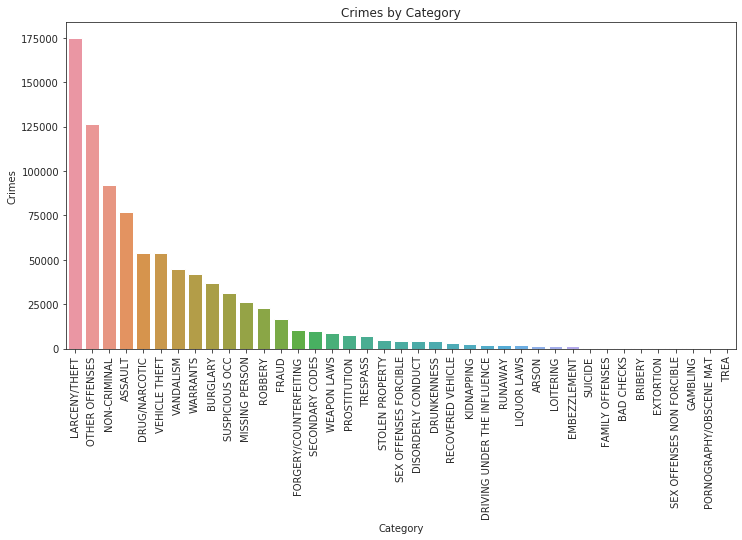

In [853]:
plt.figure(figsize=(12,6))
sns.countplot(x="Category", data=crimes_original, order=crimes_original["Category"].value_counts().index)
plt.title("Crimes by Category")
plt.ylabel("Crimes")
plt.xticks(rotation=90)
plt.show()

## **Crimes by Police Department District**

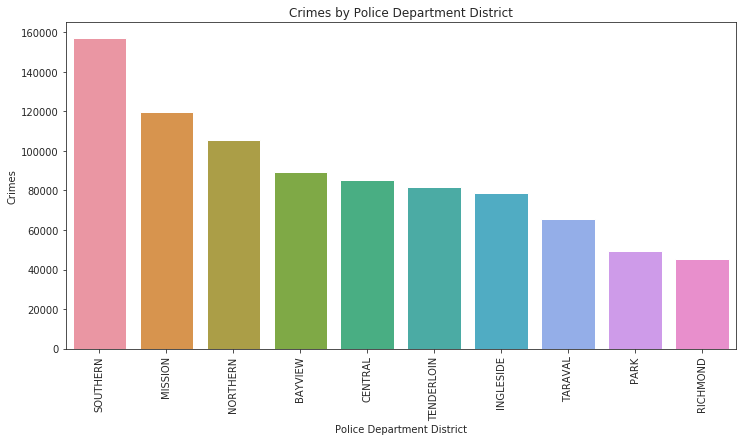

In [854]:
plt.figure(figsize=(12,6))
sns.countplot(x="PdDistrict", data=crimes_original, order=crimes_original["PdDistrict"].value_counts().index)
plt.xlabel("Police Department District")
plt.ylabel("Crimes")
plt.title("Crimes by Police Department District")
plt.xticks(rotation=90)
plt.show()

## **Crimes by Resolutions**

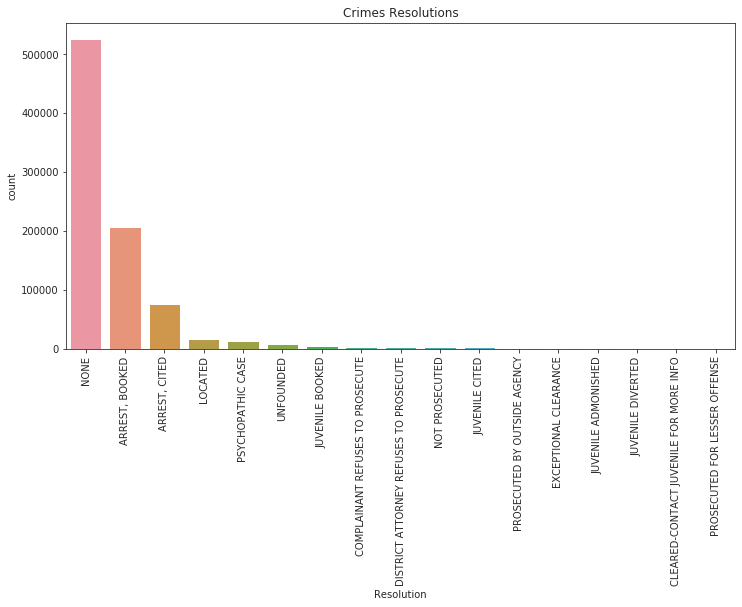

In [855]:
plt.figure(figsize=(12,6))
sns.countplot(x="Resolution", data=crimes_original, order=crimes_original["Resolution"].value_counts().index)
plt.title("Crimes Resolutions")
plt.xticks(rotation=90)
plt.show()

## **Correlation Matrix**

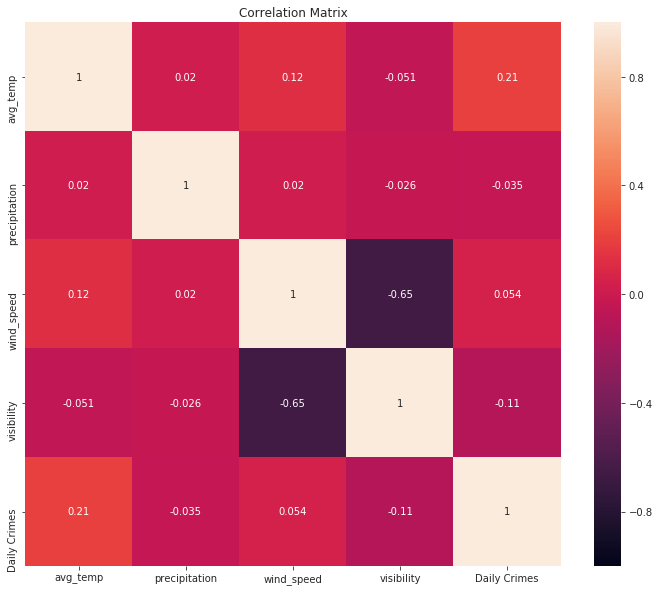

In [856]:
plt.figure(figsize=(12,10))
crimes_weather = data.resample("D").agg({"avg_temp":"mean", "precipitation":"mean", "wind_speed":"mean", "visibility":"mean", "PdDistrict":"count"}).dropna()
crimes_weather.rename(columns={"PdDistrict":"Daily Crimes"}, inplace=True)
sns.heatmap(crimes_weather.corr(), annot=True, vmin=-1, vmax=1, )
plt.title("Correlation Matrix")
plt.show()

## **Mean Daily Crimes vs. Mean Daily Temperature**

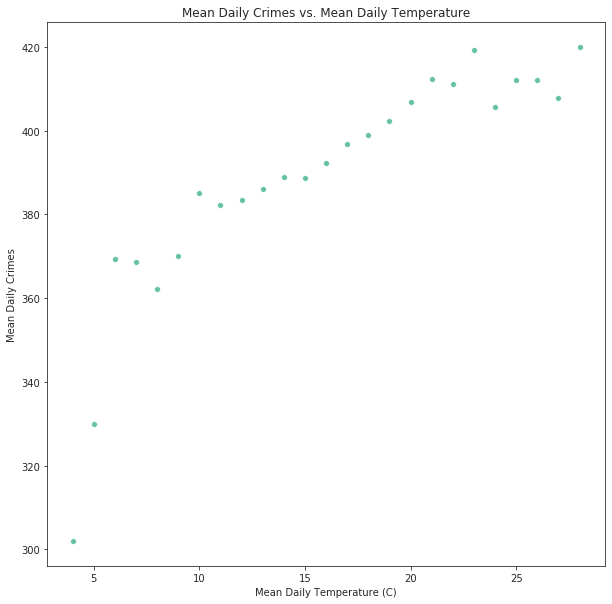

In [857]:
plt.figure(figsize=(10,10))
crimes_weather = data.resample("D").agg({"avg_temp":"mean", "PdDistrict":"count"}).dropna().groupby(by="avg_temp").mean()
sns.scatterplot(x=crimes_weather.index, y=crimes_weather["PdDistrict"])
plt.title("Mean Daily Crimes vs. Mean Daily Temperature")
plt.ylabel("Mean Daily Crimes")
plt.xlabel("Mean Daily Temperature (C)")
plt.show()

## **Average Crimes vs. Day of Month**

In [0]:
data_dom = data.copy()
data_dom["Day"] = data_dom.index.day
data_dom = data_dom.resample("D").agg({"Day":"mean", "PdDistrict":"count"}).dropna().groupby(by="Day").mean()

In [0]:
avg_line = data_dom["PdDistrict"].mean()

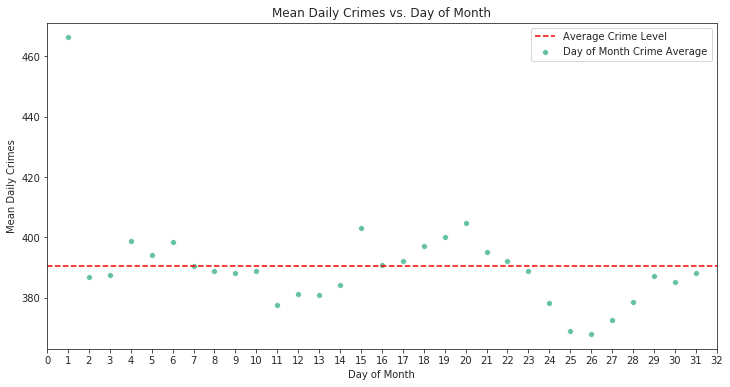

In [860]:
plt.figure(figsize=(12,6))
sns.scatterplot(x=data_dom.index, y=data_dom["PdDistrict"])
plt.title("Mean Daily Crimes vs. Day of Month")
plt.ylabel("Mean Daily Crimes")
plt.xlabel("Day of Month")
plt.xlim((1,31))
plt.xticks(ticks=[x for x in range(0, 33)])
plt.axhline(avg_line, ls='--', color="red")
plt.legend(["Average Crime Level", "Day of Month Crime Average"])
plt.show()

## **Comparison of Crime Between NFL Game Day and Regular Day**

In [0]:
data_nfl = data.copy()
data_game_day = data_nfl[data_nfl["NFL_Game_Day"].astype("int") == 1]
data_regular_day = data_nfl[data_nfl["NFL_Game_Day"]==0]

In [0]:
data_game_day_mean = data_game_day.resample("D").agg({"PdDistrict":"count"}).dropna().mean()

In [0]:
data_regular_day_mean = data_regular_day.resample("D").agg({"PdDistrict":"count"}).dropna().mean()

In [864]:
data_game_day_mean

PdDistrict    9.425321
dtype: float64

In [865]:
data_regular_day_mean

PdDistrict    186.014853
dtype: float64

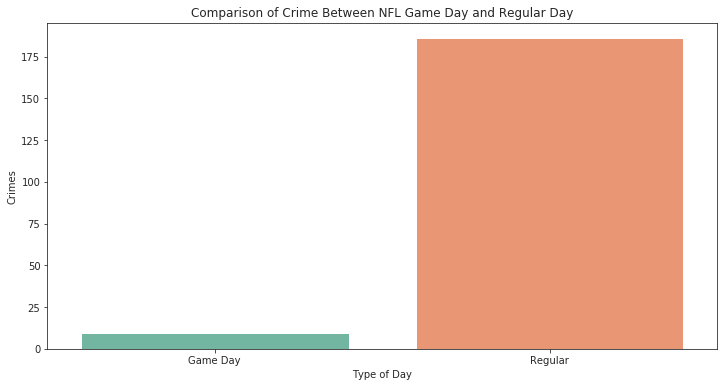

In [866]:
plt.figure(figsize=(12,6))
sns.barplot(x=["Game Day", "Regular"], y=[data_game_day_mean, data_regular_day_mean])
plt.title("Comparison of Crime Between NFL Game Day and Regular Day")
plt.ylabel("Crimes")
plt.xlabel("Type of Day")
plt.show()

## **Comparison of Crime Between NFL Home Game and Away Game**

In [0]:
data_nfl = data.copy()
data_home = data_nfl[data_nfl["NFL_Home"].astype("int") == 1]
data_away = data_nfl[data_nfl["NFL_Home"]==0]

In [0]:
data_home_mean = data_home.resample("D").agg({"PdDistrict":"count"}).dropna().mean()

In [0]:
data_away_mean = data_away.resample("D").agg({"PdDistrict":"count"}).dropna().mean()

In [870]:
data_away_mean

PdDistrict    4.525911
dtype: float64

In [871]:
data_home_mean

PdDistrict    5.006778
dtype: float64

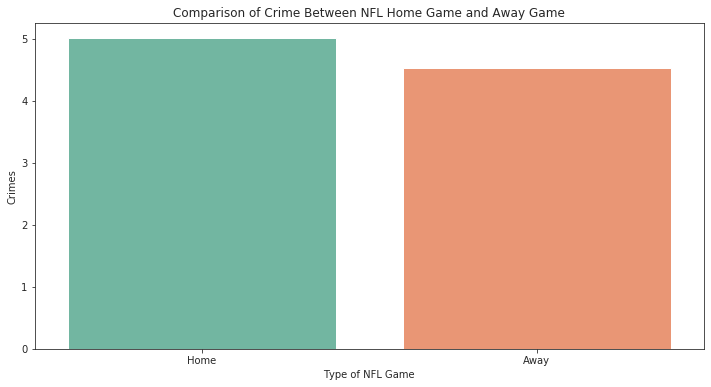

In [872]:
plt.figure(figsize=(12,6))
sns.barplot(x=["Home", "Away"], y=[data_home_mean, data_away_mean])
plt.title("Comparison of Crime Between NFL Home Game and Away Game")
plt.ylabel("Crimes")
plt.xlabel("Type of NFL Game")
plt.show()

## **Comparison of Crime Between NFL Win and Loss**

In [0]:
data_nfl = data.copy()
data_game_win = data_nfl[data_nfl["NFL_Output"] == "W"]
data_game_loss = data_nfl[data_nfl["NFL_Output"] == "L"]

In [0]:
data_game_win_mean = data_game_win.resample("D").agg({"PdDistrict":"count"}).dropna().mean()

In [0]:
data_game_loss_mean = data_game_loss.resample("D").agg({"PdDistrict":"count"}).dropna().mean()

In [876]:
data_game_win_mean

PdDistrict    4.851852
dtype: float64

In [877]:
data_game_loss_mean

PdDistrict    4.60468
dtype: float64

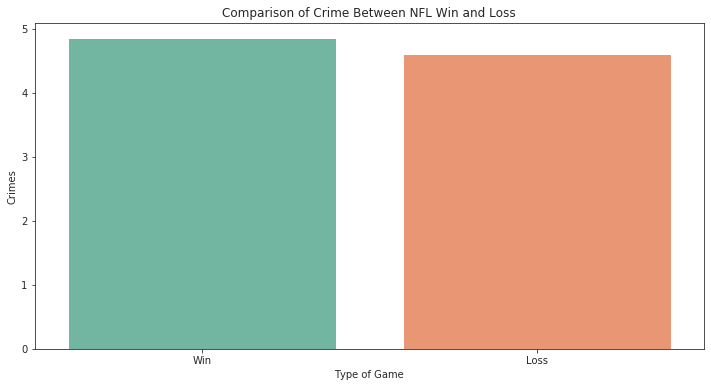

In [878]:
plt.figure(figsize=(12,6))
sns.barplot(x=["Win", "Loss"], y=[data_game_win_mean, data_game_loss_mean])
plt.title("Comparison of Crime Between NFL Win and Loss")
plt.ylabel("Crimes")
plt.xlabel("Type of Game")
plt.show()

## **Output File**

In [0]:
output = data.drop(columns=["precipitation", "wind_speed", "visibility", "NFL_Output", "NFL_Home"])

In [0]:
output = output.groupby([pd.Grouper(freq="1D"), "PdDistrict"]).agg({"DayOfWeek":"first", "PdDistrict":"count", "avg_temp":"mean", "NFL_Game_Day":"first"}).dropna()
output.rename(columns={"PdDistrict":"Crimes"}, inplace=True)
output["Day"] = test.index.get_level_values(0).day
output["Month"] = test.index.get_level_values(0).month
output["Year"] = test.index.get_level_values(0).year